<a href="https://colab.research.google.com/github/ariG23498/ft-pali-gemma/blob/main/notebooks/vanilla_paligemma_ft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://huggingface.co/datasets/ritwikraha/random-storage/resolve/main/nb-covers.png)

In [1]:
# @title Setup and Imports
! pip install -U -q transformers accelerate datasets

import re
import numpy as np
from matplotlib import pyplot as plt

from transformers import (
    AutoProcessor,
    PaliGemmaForConditionalGeneration
)
from datasets import load_dataset

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.

## Configuration

In [3]:
dataset_id = "diffusers/tuxemon"
model_id = "google/paligemma-3b-pt-224"

device = "cuda:0"
dtype = torch.bfloat16

batch_size = 4
learning_rate = 5e-5

## Dataset for Fine Tuning

In [4]:
dataset = load_dataset(dataset_id, split="train")
dataset = dataset.train_test_split(test_size=0.3)

train_dataset = dataset["train"]
val_test_dataset = dataset["test"].train_test_split(test_size=0.2)

val_dataset = val_test_dataset["train"]
test_dataset = val_test_dataset["test"]

Generating train split:   0%|          | 0/251 [00:00<?, ? examples/s]

In [6]:
processor = AutoProcessor.from_pretrained(model_id)

preprocessor_config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

In [7]:
# @title Create Data Loader
def collate_train_fn(examples):
    images = [example["image"].convert("RGB") for example in examples]

    prompt = ["Caption the image." for _ in examples]
    suffix = [example["blip_caption"] for example in examples]

    # Help from: https://github.com/huggingface/transformers/issues/30987
    inputs = processor(
        images=images,
        text=prompt,
        suffix=suffix,
        return_tensors="pt",
        padding="longest",
    )

    inputs = inputs.to(torch.bfloat16).to(device)
    return inputs

def collate_test_fn(examples):
    images = [example["image"].convert("RGB") for example in examples]

    prompt = ["Caption the image." for _ in examples]

    inputs = processor(
        images=images,
        text=prompt,
        return_tensors="pt",
        padding="longest",
    )

    inputs = inputs.to(torch.bfloat16).to(device)
    return inputs

train_dataloader = DataLoader(
    train_dataset,
    collate_fn=collate_train_fn,
    batch_size=batch_size,
    shuffle=True,
)

val_dataloader = DataLoader(
    val_dataset,
    collate_fn=collate_train_fn,
    batch_size=batch_size,
    shuffle=False,
)

test_dataloader = DataLoader(
    test_dataset,
    collate_fn=collate_test_fn,
    batch_size=batch_size,
    shuffle=False,
)

## Model creation

In [9]:
model = PaliGemmaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=dtype,
    device_map=device,
    revision="bfloat16",
)

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/paligemma/configuration_paligemma.py:137: FutureWarning: The `vocab_size` attribute is deprecated and will be removed in v4.44, Please use `text_config.vocab_size` instead.
  warnings.warn(


model.safetensors.index.json:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/862M [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [10]:
# @title Freezing everything but the attention layers

for name, param in model.named_parameters():
    if "attn" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

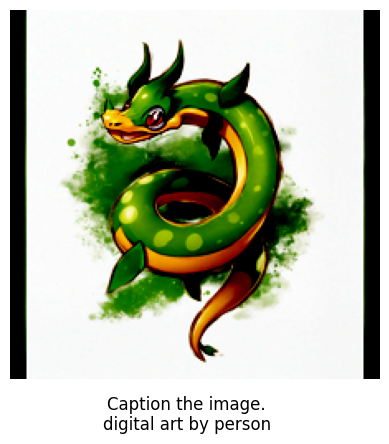

In [15]:
# @title Results _before_ Fine Tuning

test_batch = next(iter(test_dataloader))

index = 0

plt.imshow(test_batch["pixel_values"][index].permute(1, 2, 0).cpu().to(torch.float32))
plt.axis("off")

generated_outputs = model.generate(
    **test_batch,
    max_new_tokens=30,
)
generated_outputs = processor.batch_decode(
    generated_outputs,
    skip_special_tokens=True,
    clean_up_tokenization_spaces=False
)[index]

plt.figtext(
    0.5, 0.01,
    generated_outputs,
    wrap=True,
    horizontalalignment="center",
    fontsize=12
)

plt.show()

## Fine tune the model

In [16]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
model.train()

for epoch in range(10):
    for idx, batch in enumerate(train_dataloader):
        outputs = model(**batch)
        loss = outputs.loss
        if idx % 10 == 0:
            print(f"Epoch: {epoch} Iter: {idx} Loss: {loss.item():.4f}")

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

Epoch: 0 Iter: 0 Loss: 3.7527
Epoch: 0 Iter: 10 Loss: 0.7975
Epoch: 0 Iter: 20 Loss: 0.5856
Epoch: 0 Iter: 30 Loss: 0.4577
Epoch: 0 Iter: 40 Loss: 0.6825
Epoch: 1 Iter: 0 Loss: 0.2351
Epoch: 1 Iter: 10 Loss: 0.2173
Epoch: 1 Iter: 20 Loss: 0.4760
Epoch: 1 Iter: 30 Loss: 0.3291
Epoch: 1 Iter: 40 Loss: 0.2120
Epoch: 2 Iter: 0 Loss: 0.0902
Epoch: 2 Iter: 10 Loss: 0.1917
Epoch: 2 Iter: 20 Loss: 0.1585
Epoch: 2 Iter: 30 Loss: 0.3243
Epoch: 2 Iter: 40 Loss: 0.2100
Epoch: 3 Iter: 0 Loss: 0.0739
Epoch: 3 Iter: 10 Loss: 0.1708
Epoch: 3 Iter: 20 Loss: 0.0444
Epoch: 3 Iter: 30 Loss: 0.0615
Epoch: 3 Iter: 40 Loss: 0.2164
Epoch: 4 Iter: 0 Loss: 0.0399
Epoch: 4 Iter: 10 Loss: 0.0398
Epoch: 4 Iter: 20 Loss: 0.0174
Epoch: 4 Iter: 30 Loss: 0.1657
Epoch: 4 Iter: 40 Loss: 0.1199
Epoch: 5 Iter: 0 Loss: 0.0895
Epoch: 5 Iter: 10 Loss: 0.0446
Epoch: 5 Iter: 20 Loss: 0.0681
Epoch: 5 Iter: 30 Loss: 0.0566
Epoch: 5 Iter: 40 Loss: 0.1197
Epoch: 6 Iter: 0 Loss: 0.0227
Epoch: 6 Iter: 10 Loss: 0.0082
Epoch: 6 Iter: 

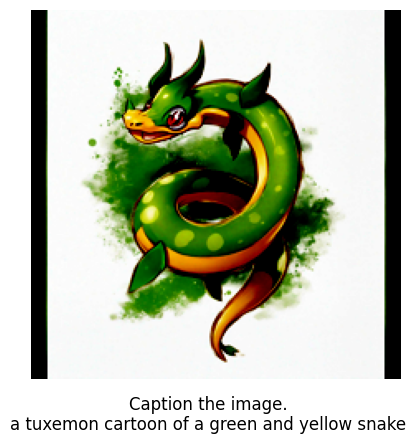

In [17]:
# @title Results _after_ Fine Tuning

index = 0

plt.imshow(test_batch["pixel_values"][index].permute(1, 2, 0).cpu().to(torch.float32))
plt.axis("off")

generated_outputs = model.generate(
    **test_batch,
    max_new_tokens=30,
)
generated_outputs = processor.batch_decode(
    generated_outputs,
    skip_special_tokens=True,
    clean_up_tokenization_spaces=False
)[index]

plt.figtext(
    0.5, 0.01,
    generated_outputs,
    wrap=True,
    horizontalalignment="center",
    fontsize=12
)

plt.show()